In [1040]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nusretkizilaslan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nusretkizilaslan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1041]:
def convert_to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    special_characters_to_be_removed = ["'", ",", "*", "_", "(", ")", "/", "&", "%", "+", "^", ";", "=", "\\", "-", "%",'"',".",":",">","?","!"]    
    cleaned_text = ''
    # Removing special characters from the text
    for char in text:
        if char in special_characters_to_be_removed:
            cleaned_text += ' '
        else:
            cleaned_text += char


    return cleaned_text

def tokenize(text):
    return word_tokenize(text) 


def remove_stopwords(wordlist):
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in wordlist if word.lower() not in stop_words]
    return filtered_words

def stemming(wordlist):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in wordlist]
    return stemmed_words

def convert_list_to_string(wordlist):
    review = ""
    for word in wordlist:
        review = review + word + " "
    return review

def clean_text(text):
    # Lowercase
    cleaned = convert_to_lowercase(text)

    # Remove punctuation and special characters
    cleaned = remove_special_characters(cleaned)

    wordlist = tokenize(cleaned)

    # Stopword removal
    wordlist = remove_stopwords(wordlist)
    
    # Stemming
    wordlist = stemming(wordlist)

    cleaned_text = convert_list_to_string(wordlist)

    return cleaned_text

In [1042]:
data_path = "./project-material/dataset/dataset/*.html" #Herkes kendi bilgisayarına uygun olarak değiştirsin.

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:07<00:00, 17.49it/s]


# TEST

In [1043]:
data_path = "./project-material/chatgpt_data/*.html" #Herkes kendi bilgisayarına uygun olarak değiştirsin.

code2convos_test = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos_test[file_code] = convo_texts

100%|██████████| 188/188 [00:15<00:00, 11.75it/s]


In [1044]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


# TEST

In [1045]:
pprint(code2convos_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"][0])

{'role': 'user',
 'text': '3) Understanding the dataset & Preprocessing (15 pts)\n'
         'Understanding the Dataset: (5 pts)\n'
         '\n'
         'Find the shape of the dataset (number of samples & number of '
         'attributes). (Hint: You can use the shape function)\n'
         'Display variable names (both dependent and independent).\n'
         'Display the summary of the dataset. (Hint: You can use the info '
         'function)\n'
         'Display the first 5 rows from training dataset. (Hint: You can use '
         'the head function) for this code # code here\n'
         'file_path = "cs210_hw2_dataset.csv"  # Replace with the actual path '
         'of the file\n'
         'penguins_data = pd.read_csv(file_path)'}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [1046]:
prompts = []
code_and_length = dict()
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            cleaned_convo = clean_text(conv["text"])
            prompts.append(cleaned_convo)
            user_prompts.append(cleaned_convo)
    code_and_length[code] = len(user_prompts)
    code2prompts[code] = user_prompts    


# TEST

In [1047]:
prompts_test = []
code_and_length_test = dict()
code2prompts_test = defaultdict(list)
for code , convos in code2convos_test.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            cleaned_convo = clean_text(conv["text"])
            prompts_test.append(cleaned_convo)
            user_prompts.append(cleaned_convo)
    code_and_length_test[code] = len(user_prompts)
    code2prompts_test[code] = user_prompts    

In [1048]:
prompts[3]


'already provide code please recreate part shuffling needed 1 shuffle dataframe named df 2 separate dataset feature matrix x target vector column health metrics columns included x 3 split data training test sets 80 data training 20 testing ensure splitting random '

# TEST

In [1049]:
prompts_test[3]

'give whole code '

In [1050]:
responses = []
code2response = defaultdict(list)
for code , convos in code2convos.items():
    assistant_response = []
    for conv in convos:
        if conv["role"] == "assistant":
            cleaned_convo = clean_text(conv["text"])
            responses.append(cleaned_convo)
            assistant_response.append(cleaned_convo)
    code2response[code] = assistant_response    


# TEST

In [1051]:
responses_test = []
code2response_test = defaultdict(list)
for code , convos in code2convos_test.items():
    assistant_response = []
    for conv in convos:
        if conv["role"] == "assistant":
            cleaned_convo = clean_text(conv["text"])
            responses_test.append(cleaned_convo)
            assistant_response.append(cleaned_convo)
    code2response_test[code] = assistant_response    

In [1052]:
responses[0]

'load csv file pandas dataframe python using pandas read csv function specific csv file pythoncopy codeimport pandas pd # specify file path file path cs412 hw1 dataset csv # load csv file pandas dataframe df pd read csv file path # display first rows dataframe verify data loaded print df head code assumes csv file cs412 hw1 dataset csv directory python script jupyter notebook file different directory specify full path file file path variable pd read csv function automatically infer column names first row csv file need explicitly specify column names unless different provided access columns dataframe using names e g df [ species ] df [ island ] etc '

# TEST

In [1053]:
responses_test[0]

'code seems generating evaluating two hypothetical features machine learning model let break hypothetical feature 1 daily fish consumptionformula calculates ratio penguin body mass mean body mass within dietary group interpretation intends capture penguin daily fish consumption relates body mass concerning average body mass dietary group hypothetical feature 2 activity indexformula computes ratio penguin flipper length body mass interpretation feature aims represent activity index based relationship penguin flipper length body mass finally code calculates correlations two engineered features target variable train correlation values closer 1 1 indicate strong linear relationship target variable values closer 0 suggest weaker relationship want assistance anything specific related features correlations target variable '

In [1054]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing
Understanding the Dataset:
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

* Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
- Re-train model with the hyperparameters you have chosen in part 5).
- Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
- Predict the labels of testing data using the tree you have trained in step 6.
- Report the classification accuracy.
- Plot & investigate the confusion matrix. Fill the following blanks.
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split""",
#####################
]

**Questions Cleaning**

In [1055]:

questions_cleaned = []

for question in questions:
    cleaned_question  = clean_text(question)
    questions_cleaned.append(cleaned_question)

questions_cleaned

['initialize first make copy notebook given starter make sure choose connect form upper right may upload data section left colab right click csv file get path file clicking copy path using loading data ',
 'load training dataset read csv file pandas library ',
 'understanding dataset preprocessing understanding dataset find shape dataset number samples number attributes hint use shape function display variable names dependent independent display summary dataset hint use info function display first 5 rows training dataset hint use head function preprocessing check missing values dataset either drop values fill common values corresponding rows careful enough data training model encode categorical labels mappings given cell hint use map function ',
 'set x split data shuffle dataset seperate dependent variable x independent variable column health metrics rest x split training test sets 80 20 respectively ',
 'features correlations correlations features health calculate correlations featur

In [1056]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions_cleaned)

In [1057]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions_cleaned).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF


,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,www,x15szmlszq,xi,xlabel,xp,xt,xticklabels,xticks,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yearly,years,yerine,yes,yet,yield,yiä,ylabel,yle,yo,youre,youve,ypred,yticklabels,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1058]:
code2prompts_tf_idf = dict()
print(len(code2prompts))
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

print(len(code2prompts_tf_idf.keys()))

127
139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html
123


# TEST

In [1059]:
code2prompts_tf_idf_test = dict()
print(len(code2prompts_test))
for code, user_prompts in code2prompts_test.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF_test = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf_test[code] = prompts_TF_IDF_test

print(len(code2prompts_tf_idf_test.keys()))

188
188


In [1060]:
code2responses_tf_idf = dict()
print(len(code2response))
for code, assistant_response in code2response.items():
    if len(assistant_response) == 0:
        # some files have issues
        print(code+".html")
        continue
    responses_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2responses_tf_idf[code] = responses_TF_IDF

print(len(code2responses_tf_idf.keys()))


127
139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html
123


# TEST

In [1061]:
code2responses_tf_idf_test = dict()
print(len(code2response_test))
for code, assistant_response in code2response_test.items():
    if len(assistant_response) == 0:
        # some files have issues
        print(code+".html")
        continue
    responses_TF_IDF_test = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2responses_tf_idf_test[code] = responses_TF_IDF_test

print(len(code2responses_tf_idf_test.keys()))



188
188


In [1062]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,www,x15szmlszq,xi,xlabel,xp,xt,xticklabels,xticks,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yearly,years,yerine,yes,yet,yield,yiä,ylabel,yle,yo,youre,youve,ypred,yticklabels,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1063]:
code2responses_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,www,x15szmlszq,xi,xlabel,xp,xt,xticklabels,xticks,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yearly,years,yerine,yes,yet,yield,yiä,ylabel,yle,yo,youre,youve,ypred,yticklabels,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TEST

In [1064]:
code2prompts_tf_idf_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,www,x15szmlszq,xi,xlabel,xp,xt,xticklabels,xticks,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yearly,years,yerine,yes,yet,yield,yiä,ylabel,yle,yo,youre,youve,ypred,yticklabels,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1065]:
code2responses_tf_idf_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,www,x15szmlszq,xi,xlabel,xp,xt,xticklabels,xticks,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yearly,years,yerine,yes,yet,yield,yiä,ylabel,yle,yo,youre,youve,ypred,yticklabels,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1066]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 4507)

# TEST

In [1067]:
code2prompts_tf_idf_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"].shape

(46, 4507)

In [1068]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))


# TEST

In [1069]:
code2cosine_test = dict()
for code, user_prompts_tf_idf_test in code2prompts_tf_idf_test.items():
    code2cosine_test[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf_test))

In [1070]:
questions[4]

"Features and Correlations\n\n* Correlations of features with health\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [1071]:
# the homework1 assignment contains 8 questions. This part gives the similarity between the homework questions and prompts
# We aimed to find correlation between grades and the similarity of prompts to codes

code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions_cleaned))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)


# Drop the specified column
question_mapping_scores = question_mapping_scores.drop('Q_0', axis=1)

question_mapping_scores

,code,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.394948,0.509099,0.321754,0.479746,0.622109,0.164056,0.121662,0.142052
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.805033,0.774911,0.855521,0.650289,0.965108,0.685228,0.728331,0.582033
2,041f950b-c013-409a-a642-cffff60b9d4b,0.189760,0.449665,0.301927,0.617877,0.311813,0.386523,0.510859,0.176226
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.146757,0.187544,0.318891,0.336107,0.320250,0.526739,0.303476,0.366476
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.622528,0.798056,0.621542,0.700588,0.875430,0.515486,0.872884,0.567193
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.142846,0.164871,0.274123,0.182165,0.443059,0.886185,0.844195,0.724126
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.099313,0.211300,0.947343,0.748102,0.859355,0.328348,0.842073,0.644590
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,1.000000,1.000000,0.941366,0.951732,0.946199,0.759178,0.950215,0.542175
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,1.000000,0.970155,0.676857,0.892023,0.832719,0.886185,0.884659,0.766848


# TEST

In [1072]:
code2questionmapping_test = dict()
for code, cosine_scores in code2cosine_test.items():
    code2questionmapping_test[code] = code2cosine_test[code].max(axis=1).tolist()


question_mapping_scores_test = pd.DataFrame(code2questionmapping_test).T
question_mapping_scores_test.reset_index(inplace=True)
question_mapping_scores_test.rename(columns={i: f"Q_{i}" for i in range(len(questions_cleaned))}, inplace=True)
question_mapping_scores_test.rename(columns={"index" : "code"}, inplace=True)



# Drop the specified column
question_mapping_scores_test = question_mapping_scores_test.drop('Q_0', axis=1)
question_mapping_scores_test 

,code,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,0.010874,0.082528,0.094017,0.266125,0.938649,0.213894,0.426632,0.020458
1,00aea02f-a95a-4c04-8be3-777461732cdf,0.291127,0.459530,0.621542,0.708847,0.131103,0.559291,0.740705,0.592791
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,0.557861,0.814491,0.799713,0.800492,0.783484,0.630765,0.457310,0.724126
3,05029661-f8d8-441b-9cab-3c79f28a8b26,0.805033,0.814491,0.902063,0.700588,0.965108,0.364526,0.884659,0.785277
4,059a146e-a37c-498f-8c0b-5a78204249cb,0.459507,0.849565,0.947343,0.691831,0.089886,0.145486,0.797690,0.592791
...,...,...,...,...,...,...,...,...,...
183,fab774ac-38c8-4d86-910c-7ad0fa8470c5,0.790668,0.655094,0.885730,0.717841,0.835083,0.886185,0.599643,0.539440
184,fac3042d-d72d-43a7-9170-a424e3061fac,0.163800,0.814491,0.947343,0.885028,0.872983,0.619382,0.597463,0.592791
185,fbf473eb-ea6f-4a4a-b2d8-405bc09f9850,0.164279,0.325998,0.266531,0.565618,0.681798,0.699381,0.418586,0.584471
186,fccd270d-63f8-42b6-b73e-13f6d3e5f612,0.805033,0.814491,0.947343,0.700588,0.965108,0.851005,0.728331,0.823586


In [1073]:
threshold = 0.5

# Length of the chat


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [1074]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "entropy", "impurity","gain","hyperparameter","sure","understand","please"]
print(keywords2search)
keywords2search = [k.lower() for k in keywords2search]

turkish_characters = ['ç', 'ğ', 'ı', 'ö', 'ş', 'ü', 'Ç', 'Ğ', 'İ', 'Ö', 'Ş', 'Ü']

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # check the similarity with the previous response
            
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)

            for turkish_char in turkish_characters:
                code2features[code]['#turkish_characters'] += len(re.findall(turkish_char, text))
                
        else:
            # ChatGPT Responses
            kw = "impurity"
            code2features[code][f"#response_{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))
            
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

['error', 'no', 'thank', 'next', 'entropy', 'impurity', 'gain', 'hyperparameter', 'sure', 'understand', 'please']
139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


# TEST

In [1075]:
code2features_test = defaultdict(lambda : defaultdict(int))

for code, convs in code2convos_test.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features_test[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features_test[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features_test[code]["prompt_avg_chars"] += len(text)

            for turkish_char in turkish_characters:
                code2features_test[code]['#turkish_characters'] += len(re.findall(turkish_char, text))
        else:
            # ChatGPT Responses
            kw = "impurity"
            code2features_test[code][f"#response_{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))
            
            code2features_test[code]["response_avg_chars"] += len(text)

        code2features_test[code]["prompt_avg_chars"] /= code2features_test[code]["#user_prompts"]   
        code2features_test[code]["response_avg_chars"] /= code2features_test[code]["#user_prompts"]

In [1076]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,response_avg_chars,#response_impurity
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,2.205748,0.0,212.206370,0.0
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.304163,0.0,113.633582,0.0
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,0.262324,0.0,17.187601,0.0
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.123346,0.0,107.092566,0.0
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,0.017986,0.0,18.850913,18.0


# TEST

In [1077]:
df_test = pd.DataFrame(code2features_test).T
df_test.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,response_avg_chars,#response_impurity
00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.105281,0.0,26.788701,0.0
00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.098639,0.0,68.348483,0.0
04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,7.0,5.0,1.0,0.0,0.0,0.0,0.956996,0.0,37.435518,27.0
05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,4.0,5.0,0.0,1.0,0.0,0.008067,0.0,17.912278,1.0
059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,5.0,3.0,1.0,0.0,1.0,1.0,0.367686,0.0,121.715104,1.0


In [1078]:
# reading the scores
scores = pd.read_csv("./project-material/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


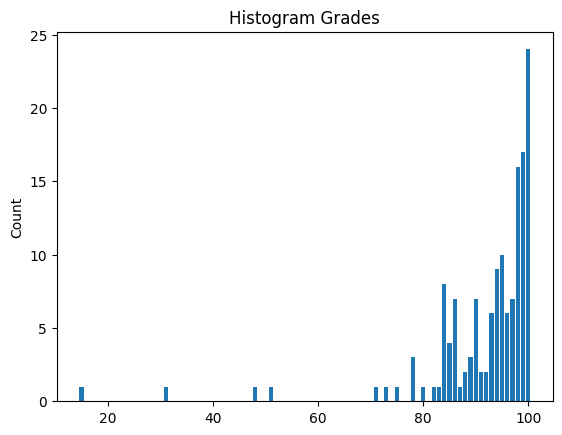

In [1079]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()



In [1080]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,response_avg_chars,#response_impurity
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,2.205748,0.0,212.206370,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.304163,0.0,113.633582,0.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,0.262324,0.0,17.187601,0.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.123346,0.0,107.092566,0.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,0.017986,0.0,18.850913,18.0


# TEST

In [1081]:
df_test.reset_index(inplace=True, drop=False)
df_test.rename(columns={"index": "code"}, inplace=True)
df_test.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,response_avg_chars,#response_impurity
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.105281,0.0,26.788701,0.0
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.098639,0.0,68.348483,0.0
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,7.0,5.0,1.0,0.0,0.0,0.0,0.956996,0.0,37.435518,27.0
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,4.0,5.0,0.0,1.0,0.0,0.008067,0.0,17.912278,1.0
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,5.0,3.0,1.0,0.0,1.0,1.0,0.367686,0.0,121.715104,1.0


In [1082]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,response_avg_chars,#response_impurity,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,2.205748,0.0,212.206370,0.0,0.394948,0.509099,0.321754,0.479746,0.622109,0.164056,0.121662,0.142052
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.304163,0.0,113.633582,0.0,0.805033,0.774911,0.855521,0.650289,0.965108,0.685228,0.728331,0.582033
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,0.262324,0.0,17.187601,0.0,0.189760,0.449665,0.301927,0.617877,0.311813,0.386523,0.510859,0.176226
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.123346,0.0,107.092566,0.0,0.146757,0.187544,0.318891,0.336107,0.320250,0.526739,0.303476,0.366476
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,0.017986,0.0,18.850913,18.0,0.622528,0.798056,0.621542,0.700588,0.875430,0.515486,0.872884,0.567193


# TEST

In [1083]:
df_test = pd.merge(df_test, question_mapping_scores_test, on="code", how="left")
df_test.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,response_avg_chars,#response_impurity,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.105281,0.0,26.788701,0.0,0.010874,0.082528,0.094017,0.266125,0.938649,0.213894,0.426632,0.020458
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.098639,0.0,68.348483,0.0,0.291127,0.459530,0.621542,0.708847,0.131103,0.559291,0.740705,0.592791
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,7.0,5.0,1.0,0.0,0.0,0.0,0.956996,0.0,37.435518,27.0,0.557861,0.814491,0.799713,0.800492,0.783484,0.630765,0.457310,0.724126
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,4.0,5.0,0.0,1.0,0.0,0.008067,0.0,17.912278,1.0,0.805033,0.814491,0.902063,0.700588,0.965108,0.364526,0.884659,0.785277
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,5.0,3.0,1.0,0.0,1.0,1.0,0.367686,0.0,121.715104,1.0,0.459507,0.849565,0.947343,0.691831,0.089886,0.145486,0.797690,0.592791


#### Merging scores with features

In [1084]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,response_avg_chars,#response_impurity,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,2.205748,0.0,212.206370,0.0,0.394948,0.509099,0.321754,0.479746,0.622109,0.164056,0.121662,0.142052,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.304163,0.0,113.633582,0.0,0.805033,0.774911,0.855521,0.650289,0.965108,0.685228,0.728331,0.582033,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,0.262324,0.0,17.187601,0.0,0.189760,0.449665,0.301927,0.617877,0.311813,0.386523,0.510859,0.176226,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.123346,0.0,107.092566,0.0,0.146757,0.187544,0.318891,0.336107,0.320250,0.526739,0.303476,0.366476,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,0.017986,0.0,18.850913,18.0,0.622528,0.798056,0.621542,0.700588,0.875430,0.515486,0.872884,0.567193,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,0.0,0.0,4.0,0.0,8.0,1.0,0.0,0.0,0.0,0.118153,0.0,131.912683,0.0,0.142846,0.164871,0.274123,0.182165,0.443059,0.886185,0.844195,0.724126,93.0
136,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1.0,1.0,1.0,1.0,6.0,0.0,10.0,1.0,0.0,1.0,1.0,0.120614,0.0,8.186395,21.0,0.099313,0.211300,0.947343,0.748102,0.859355,0.328348,0.842073,0.644590,100.0
137,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,0.0,4.0,3.0,0.0,2.0,1.0,0.0,2.0,0.0,0.105598,0.0,82.654365,0.0,1.000000,1.000000,0.941366,0.951732,0.946199,0.759178,0.950215,0.542175,98.0
138,f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,0.0,0.0,1.0,3.0,0.0,3.0,1.0,0.0,0.0,0.0,0.124168,0.0,201.260014,1.0,1.000000,0.970155,0.676857,0.892023,0.832719,0.886185,0.884659,0.766848,100.0


In [1085]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 24) (122,)


# TEST

In [1086]:
XTEST = df_test[df_test.columns[1:]].to_numpy()
XTEST_codes = df_test["code"].to_numpy()

#### Train/Test split

In [1087]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

**Neural Network (Nusret)**

In [1088]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Assuming 'X' contains your features and 'y' contains the target variable ('grade')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model with a lower learning rate
model.compile(optimizer= Adam(learning_rate=0.0005), loss='mean_squared_error')

# Number of splits for cross-validation
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mse_values = []
mae_values = []
mape_values = []
accuracy_values = []

# Perform cross-validation
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=0)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - predictions.flatten()) / y_test)) * 100
    
    # Calculate accuracy (adjust threshold as needed)
    threshold = 5  # Adjust as needed for your specific problem
    correct_predictions = np.sum(np.abs(predictions.flatten() - y_test) < threshold)
    total_predictions = len(y_test)
    accuracy = correct_predictions / total_predictions * 100

    mse_values.append(mse)
    mae_values.append(mae)
    mape_values.append(mape)
    accuracy_values.append(accuracy)

    print(f'MSE: {mse}, MAE: {mae}, MAPE: {mape}%, Accuracy: {accuracy}%')

# Calculate the mean values across all folds
mean_mse = np.mean(mse_values)
mean_mae = np.mean(mae_values)
mean_mape = np.mean(mape_values)
mean_accuracy = np.mean(accuracy_values)

print(f'Mean Squared Error across {n_splits} folds: {mean_mse}')
print(f'Mean Absolute Error across {n_splits} folds: {mean_mae}')
print(f'Mean Absolute Percentage Error across {n_splits} folds: {mean_mape}%')
print(f'Mean Accuracy across {n_splits} folds: {mean_accuracy}%')


1/1 [==============================] - 0s 38ms/step
MSE: 948.1117773135153, MAE: 22.857019424438477, MAPE: 25.27575298054789%, Accuracy: 20.0%
1/1 [==============================] - 0s 10ms/step
MSE: 291.60111313548174, MAE: 11.833382263183594, MAPE: 13.951510197536365%, Accuracy: 32.0%
1/1 [==============================] - 0s 9ms/step
MSE: 70.7876590196053, MAE: 7.0167802174886065, MAPE: 7.506247795386865%, Accuracy: 41.66666666666667%
1/1 [==============================] - 0s 10ms/step
MSE: 273.63538413314814, MAE: 9.405125170946121, MAPE: 28.77250189793279%, Accuracy: 41.66666666666667%
1/1 [==============================] - 0s 10ms/step
MSE: 31.30092309220102, MAE: 4.554572105407715, MAPE: 4.74466684943384%, Accuracy: 58.333333333333336%
Mean Squared Error across 5 folds: 323.0873713387903
Mean Absolute Error across 5 folds: 11.133375836292903
Mean Absolute Percentage Error across 5 folds: 16.05013594416755%
Mean Accuracy across 5 folds: 38.733333333333334%


In [1089]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

indices_to_predict = range(24)
y_actual = []
y_predicted = []

for index_to_predict in indices_to_predict:
    # Access the specific input from the test set
    input_to_predict = X_test[index_to_predict, :]

    # If you used scaling during training, apply the same scaling to the input
    input_to_predict_scaled = scaler.transform(input_to_predict.reshape(1, -1))

    prediction = model.predict(input_to_predict_scaled)

    # Append actual and predicted values for later error calculation
    y_actual.append(y_test[index_to_predict])
    y_predicted.append(min(prediction[0][0], 100))  # Ensure the prediction is within [0, 100]

    print(f"Actual Grade: {y_test[index_to_predict]}")
    print(f"Predicted Grade: {min(prediction[0][0], 100)}")


print()
# Calculate and print the mean squared error
mse = mean_squared_error(y_actual, y_predicted)
print(f"Mean Squared Error: {mse}")

# Calculate and print the mean absolute error
mae = mean_absolute_error(y_actual, y_predicted)
print(f"Mean Absolute Error: {mae}")


1/1 [==============================] - 0s 11ms/step


Actual Grade: 99.0
Predicted Grade: 74.35872650146484
1/1 [==============================] - 0s 10ms/step
Actual Grade: 90.0
Predicted Grade: 94.5199203491211
1/1 [==============================] - 0s 11ms/step
Actual Grade: 99.0
Predicted Grade: 69.73027038574219
1/1 [==============================] - 0s 10ms/step
Actual Grade: 95.0
Predicted Grade: 79.66973114013672
1/1 [==============================] - 0s 9ms/step
Actual Grade: 100.0
Predicted Grade: 100
1/1 [==============================] - 0s 9ms/step
Actual Grade: 100.0
Predicted Grade: 100
1/1 [==============================] - 0s 9ms/step
Actual Grade: 98.0
Predicted Grade: 100
1/1 [==============================] - 0s 10ms/step
Actual Grade: 84.0
Predicted Grade: 100
1/1 [==============================] - 0s 10ms/step
Actual Grade: 84.0
Predicted Grade: 100
1/1 [==============================] - 0s 10ms/step
Actual Grade: 99.0
Predicted Grade: 82.16242218017578
1/1 [==============================] - 0s 10ms/step
Actual Grade

In [1094]:
# Real test

index_to_test = -6

# Access the specific input from the test set
input_to_predict = XTEST[index_to_test, :]


# If you used scaling during training, apply the same scaling to the input
input_to_predict_scaled = scaler.transform(input_to_predict.reshape(1, -1))



prediction = model.predict(input_to_predict_scaled)

# If you used scaling during training, apply the same scaling to the input
input_to_predict_scaled = scaler.transform(input_to_predict.reshape(1, -1))

print(f"Predicted Code: {XTEST_codes[index_to_test]}")
print(f"Predicted Grade: {min(prediction[0][0],100)}")

1/1 [==============================] - 0s 11ms/step
Predicted Code: f9534a6b-e75b-4540-a86c-fa17494849e9
Predicted Grade: 91.92696380615234


**Gradient Boost (Ali)**

In [1091]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold


k_fold = KFold(n_splits=5, shuffle=True, random_state=42)  # You can choose the number of folds (5 is common)


# Assuming 'X' contains your features and 'y' contains the target variable ('grade')


# Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}
# Mean Squared Error on test set: 98.0395036389909
 

# Create and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, random_state=30, max_depth=3, subsample=0.8,min_samples_split=10, min_samples_leaf=4)

scores = cross_val_score(model, X, y, cv=k_fold, scoring='neg_mean_squared_error')

print("Cross-Validation Scores:", scores)
print("Mean MSE:", -scores.mean())  # Convert back to positive for interpretation
print("Standard Deviation:", scores.std())

gb_model.fit(X, y)

# Make predictions on the test set
predictions_gb = gb_model.predict(X_test)

# Evaluate the Gradient Boosting model
mse_gb = mean_squared_error(y_test, predictions_gb)
print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')



TypeError: Cannot clone object '<keras.src.engine.sequential.Sequential object at 0x2e4b68550>' (type <class 'keras.src.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
# Make prediction

# Choose an index from X_test to test a specific data point
index_to_test = -90  # You can change this to the index you want to test

# Get the features of the specific data point
features_to_test = X[index_to_test, :].reshape(1, -1)

# Get the real target value for the specific data point
real_value = y[index_to_test]

# Make predictions for the specific data point
predicted_value = gb_model.predict(features_to_test)[0]

print(f"Real Value: {real_value}")
print(f"Predicted Value: {predicted_value}")

Real Value: 71.0
Predicted Value: 74.8336460434456


#### Predicting and Analyzing 